In [7]:
import os
import pickle
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
import seaborn as sns
sns.set(style='ticks')
from scout import io
from scout.utils import read_voxel_size

In [2]:
working_dir = '/media/jswaney/Drive/Justin/organoid_phenotyping/d35/20190419_14_35_07_AA_org1_488LP13_561LP120_642LP60/'
os.listdir(working_dir)

['niche_proximities.npy',
 'celltype_names.csv',
 'centroids.npy',
 'centroids_um.npy',
 'cyto_labels.npy',
 'cyto_profiles.npy',
 'cyto_profiles_sample.npy',
 'cyto_sample_index.npy',
 'Ex0_hist.csv',
 'Ex0_rescaled',
 'Ex1_hist.csv',
 'Ex1_rescaled',
 'Ex2_hist.csv',
 'Ex2_rescaled',
 'Ex_0_Em_0_destriped_stitched_master',
 'Ex_1_Em_1_destriped_stitched',
 'Ex_2_Em_2_destriped_stitched',
 'mesh_ventricles.pkl',
 'metadata.txt',
 'niche_labels.npy',
 'niche_names.csv',
 'nuclei_binary.zarr',
 'nuclei_fluorescence',
 'nuclei_foreground.zarr',
 'nuclei_gating.npy',
 'nuclei_morphologies.csv',
 'nuclei_probability.zarr',
 'nuclei_segmentations.npz',
 'org1_ventricles.gif',
 'segment_foreground.tif',
 'segment_ventricles.tif',
 'sox2.zarr',
 'syto.zarr',
 'syto_down6x',
 'syto_down6x.tif',
 'tbr1.zarr',
 'voxel_size.csv']

In [9]:
voxel_size = read_voxel_size(os.path.join(working_dir, 'voxel_size.csv'))
voxel_size

(2.0, 0.651, 0.651)

In [10]:
downsample_factor = (1, 6, 6)
downsampled_voxel_size = tuple([d * f for d, f in zip(voxel_size, downsample_factor)])
downsampled_voxel_size

(2.0, 3.906, 3.906)

In [4]:
foreground = io.imread(os.path.join(working_dir, 'segment_foreground.tif'))
foreground.shape, foreground.max()

((1500, 634, 634), 255)

In [5]:
mask = foreground > 0
mask.shape, mask.max()

((1500, 634, 634), True)

In [11]:
edt = distance_transform_edt(mask, sampling=downsampled_voxel_size)
edt.shape, edt.min(), edt.max()

((1500, 634, 634), 0.0, 551.368234242779)

In [13]:
io.imsave(os.path.join(working_dir, 'segment_edt.tif'), edt)

In [31]:
import matplotlib.pyplot as plt
%matplotlib notebook

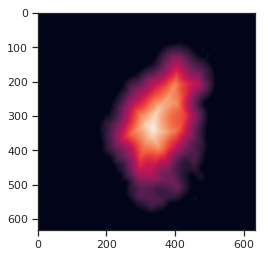

In [15]:
plt.imshow(edt[400])
plt.show()

In [34]:
boundary = np.logical_and(mask, (edt < 4))  # ~1 px boundary

<IPython.core.display.Javascript object>


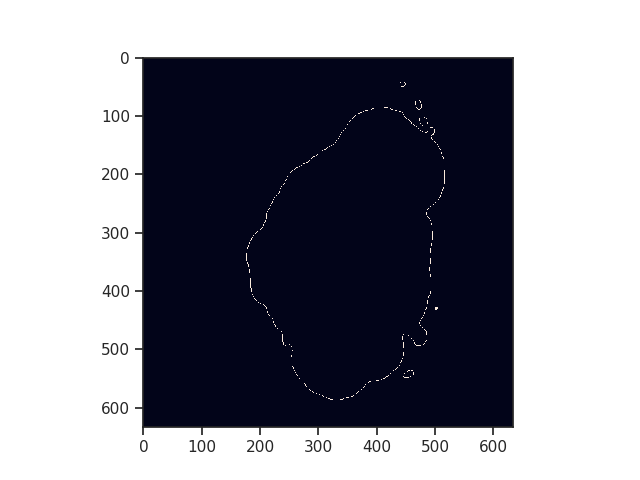

In [35]:
plt.imshow(boundary[400], clim=[0, 1])
plt.show()

In [37]:
surface_idx = np.where(boundary)
surface_pts = np.asarray(surface_idx).T * np.asarray(downsampled_voxel_size)
surface_pts.shape  # in micron

(1261462, 3)

Get the normal vectors and surface vectors

In [16]:
with open(os.path.join(working_dir, 'mesh_ventricles.pkl'), mode='rb') as f:
    mesh = pickle.load(f)
verts = mesh['verts']
faces = mesh['faces']
normals = mesh['normals']
values = mesh['values']

normals.shape

(118650, 3)

In [39]:
from sklearn.neighbors import NearestNeighbors

In [40]:
nbrs = NearestNeighbors(n_neighbors=1).fit(surface_pts)

In [41]:
dist, idx = nbrs.kneighbors(verts)

In [53]:
nearest_surface_pts = surface_pts[idx[:, 0]]
surface_vectors = nearest_surface_pts - verts
surface_vectors = surface_vectors / np.linalg.norm(surface_vectors, axis=-1)[:, np.newaxis]

In [55]:
np.linalg.norm(surface_vectors, axis=-1), np.linalg.norm(normals, axis=-1)

(array([1., 1., 1., ..., 1., 1., 1.]),
 array([1., 1., 1., ..., 1., 1., 1.], dtype=float32))

In [58]:
dot_products = (surface_vectors * normals).sum(axis=-1)
dot_products.shape, dot_products.min(), dot_products.max()

((118650,), -0.9999668155240009, 0.999992920692092)

In [73]:
thetas = np.arccos(dot_products) / np.pi * 180

<IPython.core.display.Javascript object>


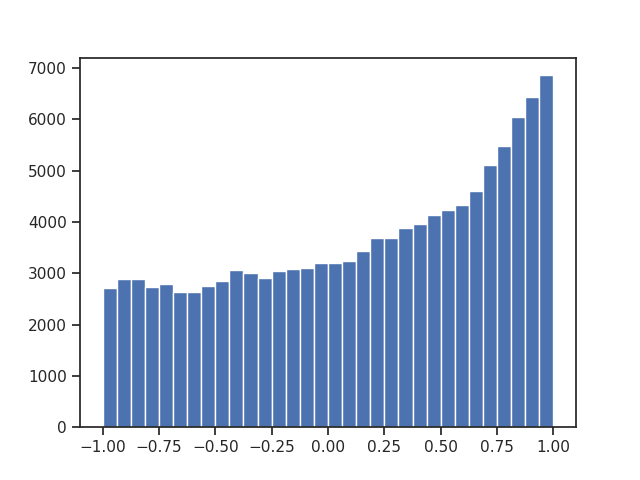

In [76]:
plt.hist(dot_products, bins=32)
plt.show()

In [77]:
labels = np.load(os.path.join(working_dir, 'cyto_labels.npy'))

labels.shape, np.unique(labels)

((118650,), array([0, 1, 2, 3, 4, 5]))

<IPython.core.display.Javascript object>


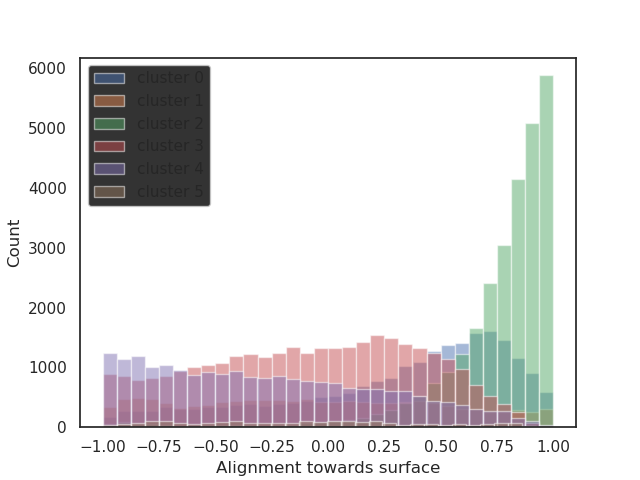

In [188]:
for lbl in np.unique(labels):
    loc = np.where(labels == lbl)[0]
    dot_products_lbl = dot_products[loc]
    plt.hist(dot_products_lbl, bins=32, alpha=0.5, label=f'cluster {lbl}')

plt.xlabel('Alignment towards surface')
plt.ylabel('Count')
plt.legend()
plt.show()

In [87]:
import pandas as pd

In [90]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

In [96]:
df = pd.DataFrame({'x': dot_products, 'g': labels})
df.head()

,x,g
0,0.698993,2
1,0.569235,2
2,0.685231,2
3,0.845228,2
4,0.940484,2


<IPython.core.display.Javascript object>


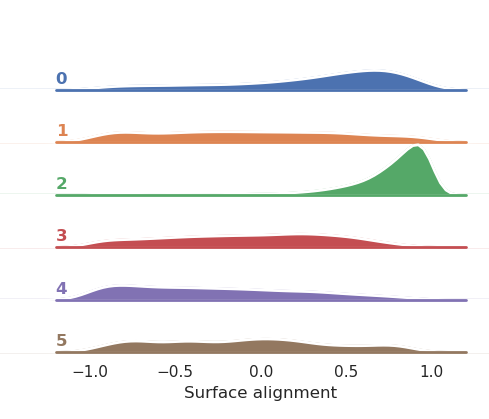

In [120]:
# Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=7, height=0.7)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
plt.xlim([-1.2, 1.2])
plt.xlabel('Surface alignment')
g.despine(bottom=True, left=True)

In [137]:
import joblib
from scout.cyto import profiles_to_features

In [135]:
model_path = os.path.abspath(os.path.join(working_dir, os.pardir, os.pardir, 'old_analysis/model_d35_d60.umap'))
model_path

'/media/jswaney/Drive/Justin/organoid_phenotyping/old_analysis/model_d35_d60.umap'

In [136]:
model = joblib.load(model_path)
model

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=None,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [138]:
profiles = np.load(os.path.join(working_dir, 'cyto_profiles.npy'))

In [139]:
x_umap = model.transform(profiles_to_features(profiles, normalize=False))

In [140]:
x_umap.shape

(118650, 2)

<IPython.core.display.Javascript object>


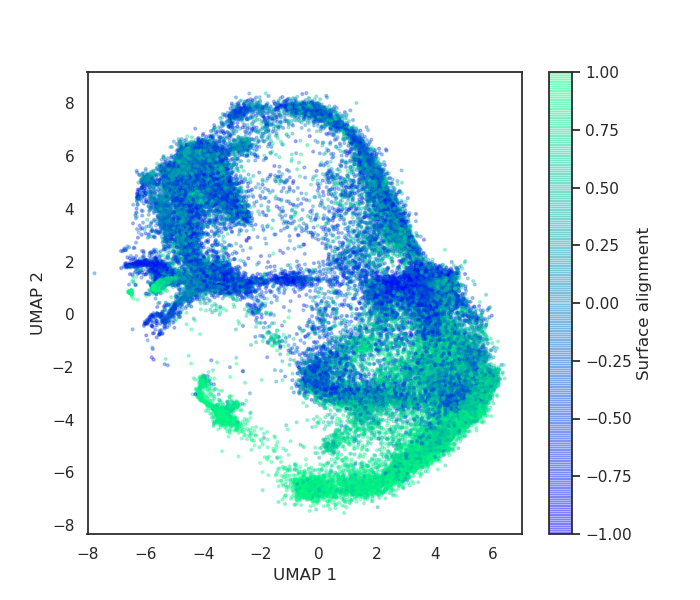

In [182]:
plt.figure(figsize=(7, 6))
plt.scatter(x_umap[:, 0], x_umap[:, 1], c=dot_products, s=4, cmap='winter', alpha=0.3, vmin=-1, vmax=1)
plt.xlim([-8, 7])
# plt.ylim([-8.5, 9])
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(label='Surface alignment')
plt.show()

In [183]:
from mayavi import mlab

In [187]:
scalars = ((dot_products + 1) / 2 * 255).astype(np.int)

surf = mlab.triangular_mesh([vert[0] for vert in verts],
                     [vert[1] for vert in verts],
                     [vert[2] for vert in verts],
                     faces,
                     colormap='cool',
                    vmin=0,
                    vmax=255,
                     scalars=scalars)

mlab.show()